 ## OCR을 통해서 번역하는 서비스를 만들어보자
- 배경이 흐릿한 한글 인식하기
- 배경이 뚜렷하고, 정자체 한글 인식하기
- 영어 표지판 인식
- 여러 언어가 있을때 인식

## 필요한 패키지 import

In [19]:
import os
import cv2   
import matplotlib.pyplot as plt

import keras_ocr

import pytesseract
from PIL import Image
from pytesseract import Output

In [15]:
img_dir = os.getenv('HOME')+'/aiffel/ocr_python/image'
file_list = os.listdir(img_dir)
file_list.sort()
file_list

['1.jpg', '2.jpg', '3.jpg', '4.jpg']

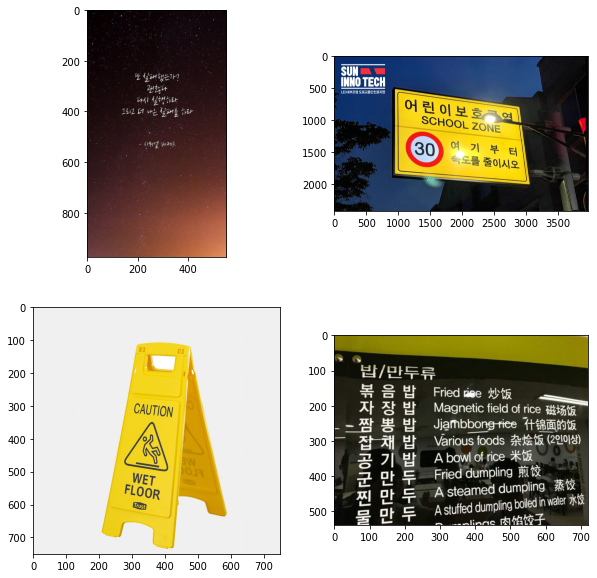

In [10]:
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    img = cv2.imread(os.path.join(img_dir, file_list[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
plt.show()

## OCR 비교
### Keras-ocr
 - 파이프라인 생성 -> recognize() 함수에 이미지 넣기 -> 시각화

In [12]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [16]:
file_list2 = ['1.jpg',
 '2.jpg',
 '3.jpg',
 '4.jpg']

In [17]:
images = [keras_ocr.tools.read(os.path.join(img_dir, file)) for file in file_list2]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, file)]) for file in file_list2]

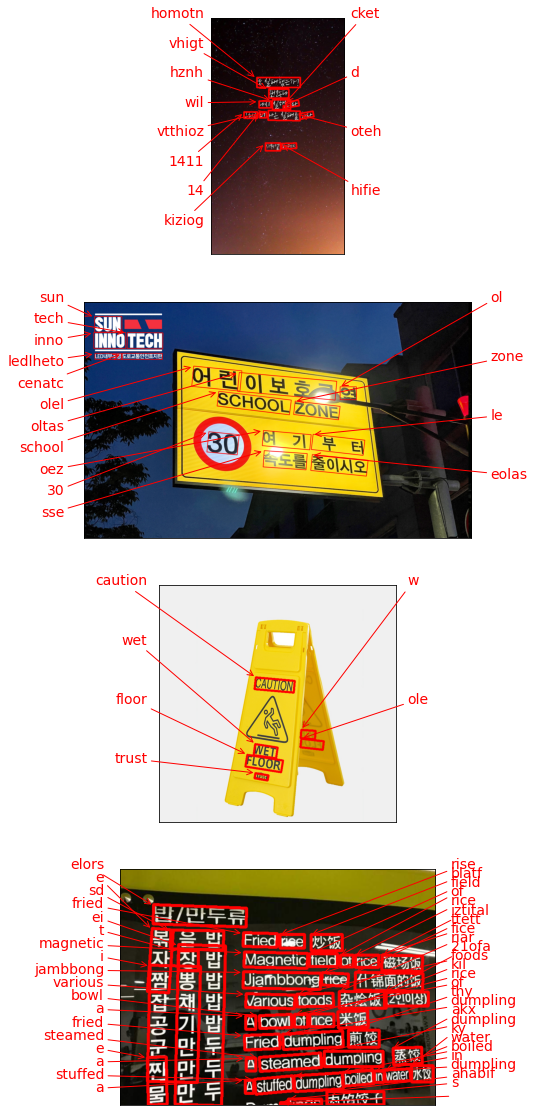

In [18]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

- 역시나 keras-ocr은 한글 detection은 잘 되지만, recognition은 잘 안되는 모습을 보이고,  
  영어는 잘 인식되는 모습을 보인다.
- 사진이 영어인지, 한글인지에 따라서 처리하는 로직이 다르게 적용 된는 것에는 무리가 따른다.
- 마지막 사진처럼 영어 이외에 여러가지 글자가 있는 경우에는 사용하기 어려운것으로 보인다.

### 태서렉트

In [44]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [43]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

- 한글 결과

In [42]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/image'

for file in file_list:
    path = os.path.join(img_dir, file)
    work_dir = os.path.join(img_dir, file.split(".")[0])
    print(path)
    cropped_image_path_list = crop_word_regions(os.path.join(img_dir, file), work_dir)
    recognize_images(cropped_image_path_list)
    print("-"*79)

/aiffel/aiffel/ocr_python/image/1.jpg
/aiffel/aiffel/ocr_python/image/1/0000.png
/aiffel/aiffel/ocr_python/image/1/0001.png
/aiffel/aiffel/ocr_python/image/1/0002.png
/aiffel/aiffel/ocr_python/image/1/0003.png
/aiffel/aiffel/ocr_python/image/1/0004.png
/aiffel/aiffel/ocr_python/image/1/0005.png
/aiffel/aiffel/ocr_python/image/1/0006.png
/aiffel/aiffel/ocr_python/image/1/0007.png
/aiffel/aiffel/ocr_python/image/1/0008.png
/aiffel/aiffel/ocr_python/image/1/0009.png
/aiffel/aiffel/ocr_python/image/1/0010.png
/aiffel/aiffel/ocr_python/image/1/0011.png
/aiffel/aiffel/ocr_python/image/1/0012.png
/aiffel/aiffel/ocr_python/image/1/0013.png
/aiffel/aiffel/ocr_python/image/1/0014.png
/aiffel/aiffel/ocr_python/image/1/0015.png
/aiffel/aiffel/ocr_python/image/1/0016.png
나



(~

00204


0

 28

그


2

여

020


여

내

…  '

Done
-------------------------------------------------------------------------------
/aiffel/aiffel/ocr_python/image/2.jpg
/aiffel/aiffel/ocr_python/image/2/0000

- 영어 결과

In [45]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/image'

for file in file_list:
    path = os.path.join(img_dir, file)
    work_dir = os.path.join(img_dir, file.split(".")[0])
    print(path)
    cropped_image_path_list = crop_word_regions(os.path.join(img_dir, file), work_dir)
    recognize_images(cropped_image_path_list)
    print("-"*79)

/aiffel/aiffel/ocr_python/image/1.jpg
/aiffel/aiffel/ocr_python/image/1/0000.png
/aiffel/aiffel/ocr_python/image/1/0001.png
/aiffel/aiffel/ocr_python/image/1/0002.png
/aiffel/aiffel/ocr_python/image/1/0003.png
/aiffel/aiffel/ocr_python/image/1/0004.png
/aiffel/aiffel/ocr_python/image/1/0005.png
/aiffel/aiffel/ocr_python/image/1/0006.png
/aiffel/aiffel/ocr_python/image/1/0007.png
/aiffel/aiffel/ocr_python/image/1/0008.png
/aiffel/aiffel/ocr_python/image/1/0009.png
/aiffel/aiffel/ocr_python/image/1/0010.png
/aiffel/aiffel/ocr_python/image/1/0011.png
/aiffel/aiffel/ocr_python/image/1/0012.png
/aiffel/aiffel/ocr_python/image/1/0013.png
/aiffel/aiffel/ocr_python/image/1/0014.png
/aiffel/aiffel/ocr_python/image/1/0015.png
/aiffel/aiffel/ocr_python/image/1/0016.png
/aiffel/aiffel/ocr_python/image/1/0017.png
>



ee

a olla


a

ek

eo

4

Z


7

coal

se

A sa

ie

a |

Done
-------------------------------------------------------------------------------
/aiffel/aiffel/ocr_py

- 테서렉트는 keras-ocr과 다르게 언어의 선택이 가능했다.
- 하지만 ocr로 판단하기 전에 번역하려는 사진이 한글인지, 영어인지에 따라서 테서렉트의 언어 옵션을 어떤걸 선택할지 하는 과정이 추가되어야 할듯하다
- 한글과 영어 둘다 detection은 잘 하는듯 하였지만, recognition 부분에서 어딘가 어색한 부분이 있었다.


- 이 두가지 모두 google API를 활용하면 해결될 사항으로 보인다.

## 회고
- 이번 과제는 추가적인 모델을 학습하는 부분이 없이, API를 사용해보는 목적인것 같았다.
- 핸드폰이나, pdf 파일에서 보던 ocr을 다뤄볼 수 있어서 흥미로운 부분이였다.
- 요즘에는 문서나, 책을 전자 문서로 많이 변환 하다보니, ocr을 좀더 활용해서 다양한 방면으로 활용해 나갈수 있으면 좋겠다.